In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
import scienceplots

from nanonets import NanoparticleTunneling
from nanonets.utils import get_all_matrices_lattice, get_self_capacitance, get_tau_f0_SET, get_charging_energies, get_scaling_factor
from nanonets.utils import get_potential_phasor_lattice, get_current_phasor_lattice
import matplotlib.colors as mcolors

plt.style.use(["science","bright","grid"])

TAU_SET, F0_SET = get_tau_f0_SET()

def get_e_pos(L):
    return  [[(L-1)//2, 0],[0, 0],[L-1, 0],[0, (L-1)//2],[L-1, (L-1)//2],[0, L-1],[L-1, L-1],[(L-1)//2, L-1]]

### Comparing FDM & Approximation Matrix

In [3]:
L           = 7
cap0_vals   = [0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]

C_mat_true  = np.loadtxt(f"data_ref/c_mat_L={L}_new.csv")
C_u_true    = np.loadtxt(f"data_ref/c_ele_L={L}_new.csv")[:-1,:].T
cop_true    = np.linalg.inv(C_mat_true) @ C_u_true
U, s, Vh    = np.linalg.svd(cop_true, full_matrices=True)
svd_true    = s

C_mat_short = []
C_u_short   = []
cop_short   = []  
svd_short   = []
for cap0 in cap0_vals:
    G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), short_range=True)
    C_u                     = C_u.T
    C_mat                   = C_mat - (np.sum(C_mat,axis=1)-np.sum(C_u,axis=1))*np.eye(L*L,L*L) + np.eye(L*L,L*L)*cap0
    cop_mat                 = np.linalg.inv(C_mat) @ C_u
    U, s, Vh                = np.linalg.svd(cop_mat, full_matrices=True)
    
    C_mat_short.append(C_mat)
    C_u_short.append(C_u)
    cop_short.append(cop_mat)
    svd_short.append(s)

FileNotFoundError: data_ref/c_mat_L=7_new.csv not found.

In [4]:
G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), short_range=True)
0.05*C_mat[L*L//2,L*L//2]*25*1e6*1e-18

1.4029683722796917e-11

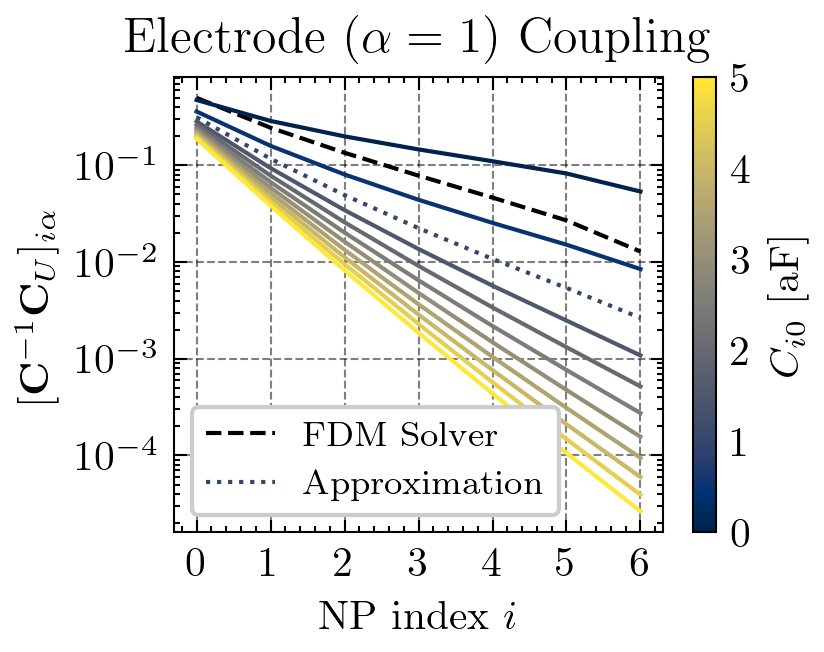

In [5]:
idx_on_line = [L//2 + n*L for n in range(L)]
cmap        = plt.get_cmap('cividis')
norm        = mcolors.Normalize(vmin=min(cap0_vals),vmax=max(cap0_vals))
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.plot(cop_true[idx_on_line,0], label='FDM Solver', color='black', ls='--')
for i, cap0 in enumerate(cap0_vals):
    if cap0 == 1.0:
        _   = ax.plot(cop_short[i][idx_on_line,0], color=cmap(norm(cap0)), ls=':', label='Approximation')
    else:
        _   = ax.plot(cop_short[i][idx_on_line,0], color=cmap(norm(cap0)))
_   = ax.set_xticks(np.arange(L))
_   = ax.set_yscale('log')
_   = ax.set_xlabel("NP index $i$")
_   = ax.set_ylabel("$[\mathbf{C}^{-1}\mathbf{C}_U]_{i\\alpha}$")
_   = ax.set_title("Electrode ($\\alpha=1$) Coupling")
_   = ax.legend(fontsize='small')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$C_{i0}~[\mathrm{aF}]$")

fig.savefig(f"plots/pdf/Coupling_Mat_FDM_vs_Short.pdf", transparent=False)
fig.savefig(f"plots/svg/Coupling_Mat_FDM_vs_Short.svg", transparent=True)
fig.savefig(f"plots/png/Coupling_Mat_FDM_vs_Short.png", transparent=False)

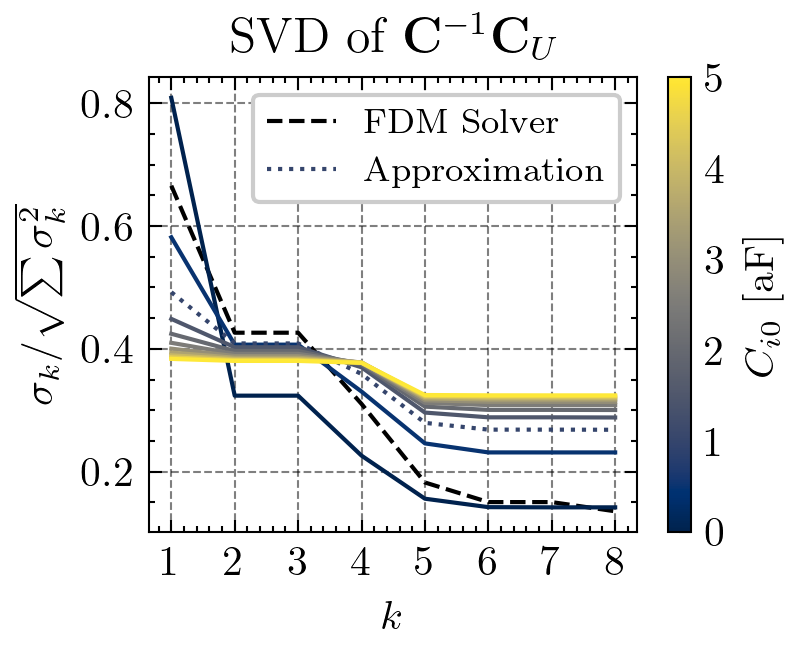

In [6]:
cmap        = plt.get_cmap('cividis')
norm        = mcolors.Normalize(vmin=min(cap0_vals),vmax=max(cap0_vals))
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.plot(np.arange(1,9), svd_true/np.sqrt(np.sum(svd_true**2)), label='FDM Solver', color='black', ls='--')
for i, cap0 in enumerate(cap0_vals):
    if cap0 == 1.0:
        _ = ax.plot(np.arange(1,9), svd_short[i]/np.sqrt(np.sum(svd_short[i]**2)), color=cmap(norm(cap0)), ls=':', label='Approximation')
    else:
        _ = ax.plot(np.arange(1,9), svd_short[i]/np.sqrt(np.sum(svd_short[i]**2)), color=cmap(norm(cap0)))
_   = ax.set_xticks(np.arange(1,9))
_   = ax.set_xlabel("$k$")
_   = ax.set_ylabel("$\sigma_k / \\sqrt{\sum\sigma_k^2}$")
_   = ax.set_title("SVD of $\mathbf{C}^{-1}\mathbf{C}_U$")
_   = ax.legend(fontsize='small', loc='upper right')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$C_{i0}~[\mathrm{aF}]$")

fig.savefig(f"plots/pdf/SVD_FDM_vs_Short.pdf", transparent=False)
fig.savefig(f"plots/svg/SVD_FDM_vs_Short.svg", transparent=True)
fig.savefig(f"plots/png/SVD_FDM_vs_Short.png", transparent=False)

### Charging Energy and Scaling

In [4]:
L_vals  = [3,4,5,6,7,8,9,10,11,12,13,14,15]
cap0    = 1.0
e_short = {}
cop_mat = {}
for L in L_vals:
    G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), short_range=True)
    C_u                     = C_u.T
    C_inv                   = np.linalg.inv(C_mat)
    cop_mat[L]              = np.min((C_inv@C_u)[:,0])
    e_short[f"$L = {L}$"]   = 2*1000*get_charging_energies(C_inv)/0.160217662

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_9498/3250201643.py:15: SyntaxWarning: invalid escape sequence '\m'
  _ = ax.set_xlabel("$2 E_{C,i} / e~[\mathrm{mV}]$")


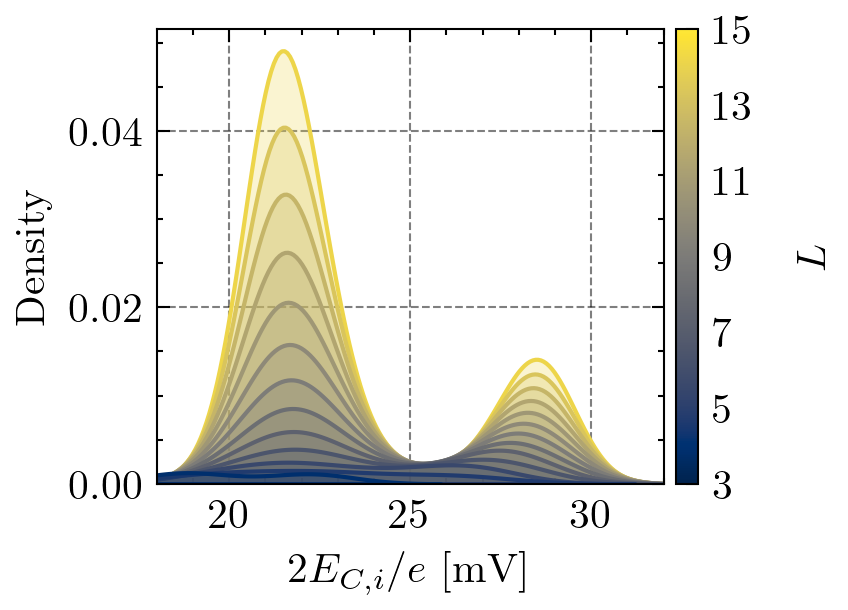

In [11]:
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

_ = sns.kdeplot(e_short, fill=True, ax=ax, palette='cividis', legend=False)

vmin, vmax = 3, 15
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('cividis')
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, pad=0.02)
cbar.set_label("$L$", labelpad=10) # Optional formatting
cbar.set_ticks(np.arange(vmin, vmax + 1, 2))
_ = ax.set_xlabel("$2 E_{C,i} / e~[\mathrm{mV}]$")
_ = ax.set_xlim(18,32)
# _ = ax.set_yscale('log')
# _ = ax.set_ylim(1e-4,1e-1)

fig.savefig(f"plots/pdf/voltage_to_charge_i.pdf", transparent=False)
fig.savefig(f"plots/svg/voltage_to_charge_i.svg", transparent=True)
fig.savefig(f"plots/png/voltage_to_charge_i.png", transparent=False)

In [6]:
edge_means = []
bulk_means = []
for i, (key, arr) in enumerate(e_short.items()):
    L           = L_vals[i]
    edge_idx    = [n for n in range(L)]+[n*L for n in range(1,L-1)]+[n*L+(L-1) for n in range(1,L-1)]+[L*L-n for n in range(1,L+1)]
    bulk_idx    = [n for n in range(L*L) if n not in edge_idx]
    edge_mean   = np.mean(arr[edge_idx])
    bulk_mean   = np.mean(arr[bulk_idx])

    edge_means.append(edge_mean)
    bulk_means.append(bulk_mean)

<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_9498/41058952.py:6: SyntaxWarning: invalid escape sequence '\i'
  _ = ax.plot(L_vals, edge_means, marker='o', label='$i \in $ Edge')
/tmp/ipykernel_9498/41058952.py:7: SyntaxWarning: invalid escape sequence '\i'
  _ = ax.plot(L_vals, bulk_means, marker='s', label='$i \in $ Bulk')
/tmp/ipykernel_9498/41058952.py:11: SyntaxWarning: invalid escape sequence '\m'
  _ = ax.set_ylabel("$\\langle 2E_{C,i} / e \\rangle~[\mathrm{mV}]$")


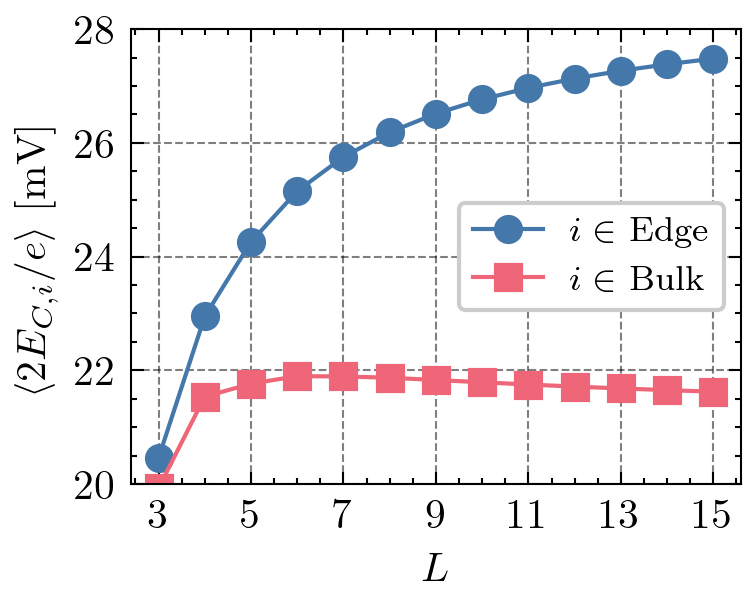

In [7]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

_ = ax.plot(L_vals, edge_means, marker='o', label='$i \in $ Edge')
_ = ax.plot(L_vals, bulk_means, marker='s', label='$i \in $ Bulk')
_ = ax.set_xticks(L_vals[::2])
_ = ax.set_ylim(20,28)
_ = ax.set_xlabel("$L$")
_ = ax.set_ylabel("$\\langle 2E_{C,i} / e \\rangle~[\mathrm{mV}]$")
_ = ax.legend(fontsize='small')

fig.savefig(f"plots/pdf/voltage_to_charge_i_bulk_vs_edge.pdf", transparent=False)
fig.savefig(f"plots/svg/voltage_to_charge_i_bulk_vs_edge.svg", transparent=True)
fig.savefig(f"plots/png/voltage_to_charge_i_bulk_vs_edge.png", transparent=False)

In [41]:
# Time Dependent Simulation
M = 1.5
{L_vals[i] : val for i, val in enumerate(np.round(M*np.array(edge_means)*1e-3,4))}

{3: 0.0307,
 4: 0.0344,
 5: 0.0364,
 6: 0.0377,
 7: 0.0386,
 8: 0.0393,
 9: 0.0398,
 10: 0.0401,
 11: 0.0405,
 12: 0.0407,
 13: 0.0409,
 14: 0.0411,
 15: 0.0412}

In [25]:
M = 1.5
{L_vals[i] : val for i, val in enumerate(np.round(M*np.array(bulk_means)*1e-3,4))}

{3: 0.0299,
 4: 0.0323,
 5: 0.0326,
 6: 0.0328,
 7: 0.0328,
 8: 0.0328,
 9: 0.0327,
 10: 0.0327,
 11: 0.0326,
 12: 0.0326,
 13: 0.0325,
 14: 0.0325,
 15: 0.0324}

In [48]:
# Time Dependent Simulation Ctrl
M = 1.0
np.round(M*np.array(edge_means),2)

array([20.46, 22.95, 24.26, 25.15, 25.75, 26.19, 26.51, 26.77, 26.97,
       27.13, 27.27, 27.38, 27.48])

In [45]:
# Time Independent Input / edge
M = 0.5
{L_vals[i] : val for i, val in enumerate(np.round(M*np.array(edge_means)*1e-3,4))}

{3: 0.0102,
 4: 0.0115,
 5: 0.0121,
 6: 0.0126,
 7: 0.0129,
 8: 0.0131,
 9: 0.0133,
 10: 0.0134,
 11: 0.0135,
 12: 0.0136,
 13: 0.0136,
 14: 0.0137,
 15: 0.0137}

In [49]:
# Time Independent Ctrl / edge
M = 1.0
{L_vals[i] : val for i, val in enumerate(np.round(M*np.array(edge_means)*1e-3,4))}

{3: 0.0205,
 4: 0.0229,
 5: 0.0243,
 6: 0.0252,
 7: 0.0258,
 8: 0.0262,
 9: 0.0265,
 10: 0.0268,
 11: 0.027,
 12: 0.0271,
 13: 0.0273,
 14: 0.0274,
 15: 0.0275}

In [50]:
# Time Independent Input / bulk
M = 1.0
{L_vals[i] : val for i, val in enumerate(np.round(M*np.array(bulk_means)*1e-3,4))}

{3: 0.0199,
 4: 0.0215,
 5: 0.0218,
 6: 0.0219,
 7: 0.0219,
 8: 0.0219,
 9: 0.0218,
 10: 0.0218,
 11: 0.0217,
 12: 0.0217,
 13: 0.0217,
 14: 0.0216,
 15: 0.0216}

In [40]:
# Time Independent Input / bulk
M = 0.5
{L_vals[i] : val for i, val in enumerate(np.round(M*np.array(bulk_means)*1e-3,4))}

{3: 0.01,
 4: 0.0108,
 5: 0.0109,
 6: 0.0109,
 7: 0.0109,
 8: 0.0109,
 9: 0.0109,
 10: 0.0109,
 11: 0.0109,
 12: 0.0109,
 13: 0.0108,
 14: 0.0108,
 15: 0.0108}

### Time Dependent Simulation

In [ ]:
FREQ_LIST   = np.logspace(-2,5,100)
nu_LIST     = FREQ_LIST / F0_SET

In [ ]:
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

# FDM Solver
pp      = ax.plot(nu_LIST, gain_I_true, label='FDM Solver')
for rate in poles_true[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Short Range
pp      = ax.plot(nu_LIST, gain_I_short, label='Short Range')
for rate in poles_short[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Long Range
pp      = ax.plot(nu_LIST, gain_I_long, label='Long Range')
for rate in poles_long[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Params
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-4, 1e2)
_ = ax.set_ylabel("$\mathcal{G}_I(\\nu)$ [dB]")
_ = ax.legend(fontsize='small')


# fig.savefig(f"plots/pdf/KCL_gain_I_FDM_Short_Long.pdf", transparent=False)
# fig.savefig(f"plots/svg/KCL_gain_I_FDM_Short_Long.svg", transparent=True)
# fig.savefig(f"plots/png/KCL_gain_I_FDM_Short_Long.png", transparent=False)

In [ ]:
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

# FDM Solver
pp      = ax.plot(nu_LIST, gain_p_true, label='FDM Solver')
for rate in poles_true[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Short Range
pp      = ax.plot(nu_LIST, gain_p_short, label='Short Range')
for rate in poles_short[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Long Range
pp      = ax.plot(nu_LIST, gain_p_long, label='Long Range')
for rate in poles_long[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Params
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-4, 1e2)
_ = ax.set_ylabel("$\mathcal{G}_\\phi(\\nu)$ [dB]")
_ = ax.legend(fontsize='small')


# fig.savefig(f"plots/pdf/KCL_gain_phi_FDM_Short_Long.pdf", transparent=False)
# fig.savefig(f"plots/svg/KCL_gain_phi_FDM_Short_Long.svg", transparent=True)
# fig.savefig(f"plots/png/KCL_gain_phi_FDM_Short_Long.png", transparent=False)

In [ ]:
L           = 7
FREQ_LIST   = np.logspace(-2,5,100)
nu_LIST     = FREQ_LIST / F0_SET

for load,short in zip((True,False,False),(False,False,True)):
    if load:
        G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), short_range=short)
        C_mat = np.loadtxt(f"data_ref/c_mat_L={L}_new.csv")
        C_u = np.loadtxt(f"data_ref/c_ele_L={L}_new.csv")
    else:
        G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), load=load, short_range=short)
        C_mat = C_mat - np.eye(L*L,L*L)*get_self_capacitance()*1e-18 + 0.5*np.eye(L*L,L*L)*1e-18

    U_phasor                = np.array([0.1,0,0,0,0,0,0,0])[:,np.newaxis]
    phi_phasor              = np.mean(np.array([get_potential_phasor_lattice(G_mat, G_u, C_mat, C_u, U_phasor, 2*np.pi*freq*1e6).flatten() for freq in FREQ_LIST]),axis=1)
    I_phasor                = np.array([get_current_phasor_lattice(G_mat, G_u, C_mat, C_u, U_phasor, 2*np.pi*freq*1e6).flatten() for freq in FREQ_LIST])
    eigenvals, eigenvecs    = scipy.linalg.eig(G_mat, C_mat)
    poles_rad_s             = np.sort(np.real(eigenvals)) / (2 * np.pi)
    nu_poles                = poles_rad_s*1e-6 / F0_SET
    coup_matrix             = -1.0*np.linalg.inv(C_mat)@C_u
    U, s, Vh                = np.linalg.svd(coup_matrix, full_matrices=True)

    if load:
        gain_I_true = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
        gain_p_true = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
        C_mat_true  = C_mat
        C_u_true    = C_u
        poles_true  = nu_poles
        coup_true   = coup_matrix
        svd_true    = s
    else:
        if short:
            gain_I_short = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
            gain_p_short = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
            C_mat_short  = C_mat
            C_u_short    = C_u
            poles_short  = nu_poles
            coup_short   = coup_matrix
            svd_short    = s
        else:
            gain_I_long = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
            gain_p_long = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
            C_mat_long  = C_mat
            C_u_long    = C_u
            poles_long  = nu_poles
            coup_long   = coup_matrix
            svd_long    = s